# Fine-Tuning v1 — Clasificador de pertinencia normativa (ES)

**Diseño:** comparar *RoBERTalex* y *BERT-es (DCC UChile)* con el mismo protocolo que el baseline.

**Objetivo operativo:** priorizar **Recall** con umbral calibrado en *val* (\(t_{F2}\) y \(t_{R@X}\)).

> Este cuaderno no se ejecuta automáticamente. Revisá las rutas en la Celda 3 y luego corré celda por celda.


## 1) Instalar dependencias

In [1]:
!pip install -q --upgrade "transformers==4.44.2" "datasets>=2.20" \
    "accelerate>=1.0" "evaluate>=0.4" sentencepiece

import transformers
print("Transformers:", transformers.__version__)

Transformers: 4.44.2


## 2) Configuración básica (imports, seed, device)

In [2]:

import os, math, random, json, time, gc, re, warnings, itertools
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

import numpy as np
import pandas as pd
import transformers

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import (roc_auc_score, average_precision_score, precision_recall_curve,
                             roc_curve, precision_recall_fscore_support, confusion_matrix)

import matplotlib.pyplot as plt

from transformers import (AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from transformers.trainer_utils import set_seed

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED); np.random.seed(SEED); set_seed(SEED); torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
print("Torch:", torch.__version__)


Device: cuda
Torch: 2.8.0+cu126


## 3) Montar Drive y configurar rutas

In [3]:

from google.colab import drive
drive.mount('/content/drive')

# === Ajustá estas rutas a tu estructura ===
PROJECT_ROOT = "/content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml"

CSV_TRAIN = f"{PROJECT_ROOT}/data/labels/dataset_train_final.csv"
CSV_VAL   = f"{PROJECT_ROOT}/data/labels/dataset_val_final.csv"
CSV_TEST  = f"{PROJECT_ROOT}/data/labels/dataset_test_final.csv"

OUT_MODELS = f"{PROJECT_ROOT}/models/finetuning/ft_v1"
OUT_METRICS= f"{PROJECT_ROOT}/metrics/finetuning/ft_v1"
OUT_PLOTS  = f"{PROJECT_ROOT}/plots/finetuning/ft_v1"
OUT_MISC   = f"{PROJECT_ROOT}/artifacts/finetuning/ft_v1"

for d in [OUT_MODELS, OUT_METRICS, OUT_PLOTS, OUT_MISC]:
    os.makedirs(d, exist_ok=True)

print("Rutas OK")
print("Train:", CSV_TRAIN)
print("Val:  ", CSV_VAL)
print("Test: ", CSV_TEST)


Mounted at /content/drive
Rutas OK
Train: /content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml/data/labels/dataset_train_final.csv
Val:   /content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml/data/labels/dataset_val_final.csv
Test:  /content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml/data/labels/dataset_test_final.csv


## 4) Cargar datasets (UTF-8, separador ';') y validar etiquetas

In [4]:

def read_csv_any(path):
    for sep in [';', None]:
        for enc in ["utf-8-sig", "utf-8", "cp1252", "latin-1"]:
            try:
                return pd.read_csv(path, dtype=str, sep=sep, engine="python",
                                   encoding=enc, keep_default_na=False)
            except Exception:
                continue
    return pd.read_csv(path, dtype=str, sep=';', engine="python",
                       encoding="utf-8", encoding_errors="replace",
                       keep_default_na=False)

def pick_text_column(df):
    for c in ["fragmento","fragmento_final","texto"]:
        if c in df.columns: return c
    raise ValueError("No se encontró columna de texto (fragmento/fragmento_final/texto).")

def coerce_label_column(s: pd.Series) -> pd.Series:
    m = s.astype(str).str.strip().str.lower().map({
        "1":1, "0":0, "true":1, "false":0, "si":1, "sí":1, "no":0,
        "pertinente":1, "no_pertinente":0, "relevante":1, "no_relevante":0
    })
    if m.isna().any():
        raise ValueError("La columna 'label' debe ser binaria y estar completa (0/1).")
    return m.astype(int)

train_df = read_csv_any(CSV_TRAIN)
val_df   = read_csv_any(CSV_VAL)
test_df  = read_csv_any(CSV_TEST)

TEXT_COL = pick_text_column(train_df)
for df,name in [(train_df,"train"),(val_df,"val"),(test_df,"test")]:
    if "label" not in df.columns:
        raise ValueError(f"{name}: falta columna 'label'.")
    df["label"] = coerce_label_column(df["label"])
    df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()
    df.dropna(subset=[TEXT_COL,"label"], inplace=True)
    print(f"{name}: {len(df)} filas | positivos={df['label'].sum()} ({100*df['label'].mean():.2f}%)")

print("Columna de texto:", TEXT_COL)


train: 2369 filas | positivos=717 (30.27%)
val: 500 filas | positivos=82 (16.40%)
test: 1200 filas | positivos=44 (3.67%)
Columna de texto: fragmento


## 5) Selector de modelo y parámetros de entrenamiento

In [5]:

CHECKPOINT = "BSC-LT/RoBERTalex"  # Alternativa: "dccuchile/bert-base-spanish-wwm-cased"

MAX_LEN    = 512
BATCH_TRAIN= 8
BATCH_EVAL = 16
GRAD_ACCUM = 1

EPOCHS      = 4
LR          = 2e-5
WEIGHT_DECAY= 0.01
WARMUP_RATIO= 0.1

USE_WEIGHTED_SAMPLER = True
USE_CLASS_WEIGHTS    = False

RECALL_TARGET = 0.95

USE_FP16   = True
USE_GC     = False
SEED       = 42

print("Checkpoint:", CHECKPOINT)


Checkpoint: BSC-LT/RoBERTalex


## 6) Tokenización y datasets

In [6]:

tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

class TextDS(Dataset):
    def __init__(self, df: pd.DataFrame, text_col: str, tokenizer, max_len: int):
        self.texts = df[text_col].tolist()
        self.labels= df["label"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tokenizer(self.texts[i],
                             truncation=True, padding=False,
                             max_length=self.max_len)
        item = {k: torch.tensor(v) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

ds_train = TextDS(train_df, TEXT_COL, tokenizer, MAX_LEN)
ds_val   = TextDS(val_df,   TEXT_COL, tokenizer, MAX_LEN)
ds_test  = TextDS(test_df,  TEXT_COL, tokenizer, MAX_LEN)

collator = DataCollatorWithPadding(tokenizer=tokenizer)

pos_rate = train_df["label"].mean()
w_pos = (1.0 - pos_rate)
w_neg = (pos_rate)
class_weights = torch.tensor([w_neg, w_pos], dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu") if USE_CLASS_WEIGHTS else None

print("Train/Val/Test:", len(ds_train), len(ds_val), len(ds_test))
print("Positivos (train):", int(train_df["label"].sum()))


tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Train/Val/Test: 2369 500 1200
Positivos (train): 717


## 7) Sampler ponderado y Trainer

In [7]:

def make_weighted_sampler(df: pd.DataFrame):
    y = df["label"].astype(int).values
    counts = np.bincount(y)
    weights = 1.0 / counts
    sample_w = weights[y]
    return WeightedRandomSampler(sample_w, num_samples=len(y), replacement=True)

train_sampler = make_weighted_sampler(train_df) if USE_WEIGHTED_SAMPLER else None

class WeightedTrainer(Trainer):
    def get_train_dataloader(self):
        if train_sampler is not None:
            return DataLoader(self.train_dataset, batch_size=self.args.train_batch_size,
                              sampler=train_sampler, collate_fn=self.data_collator,
                              drop_last=False)
        return super().get_train_dataloader()

    def compute_loss(self, model, inputs, return_outputs=False):
        if class_weights is None:
            return super().compute_loss(model, inputs, return_outputs=return_outputs)
        labels = inputs.get("labels")
        outputs = model(**{k:v for k,v in inputs.items() if k!="labels"})
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()[:,1]
    auc_roc = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    return {"roc": float(auc_roc), "ap": float(ap)}


## 8) Entrenamiento con early stopping (AUC-PR en val)

In [9]:

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=2)
if USE_GC:
    model.gradient_checkpointing_enable()

args = TrainingArguments(
    output_dir=OUT_MISC + "/trainer",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="ap",
    greater_is_better=True,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRAD_ACCUM,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    logging_steps=50,
    fp16=USE_FP16,
    seed=SEED,
    save_total_limit=2,
    report_to="none",
)

callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)]

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=callbacks
)

train_out = trainer.train()
print("Best checkpoint:", trainer.state.best_model_checkpoint)

save_dir = os.path.join(OUT_MODELS, os.path.basename(CHECKPOINT).replace("/", "_"))
trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print("Modelo guardado en:", save_dir)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at BSC-LT/RoBERTalex and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Roc,Ap
1,0.163800,0.347489,0.969148,0.831801
2,0.097400,0.465112,0.970096,0.836727
3,0.049900,0.402207,0.976689,0.897907
4,0.066700,0.338960,0.976543,0.894573


Best checkpoint: /content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml/artifacts/finetuning/ft_v1/trainer/checkpoint-891
Modelo guardado en: /content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml/models/finetuning/ft_v1/RoBERTalex


## 9) Calibrar umbrales en *val* (t_F2 y t_R@X)

In [10]:

def find_t_Fbeta(y_true, scores, beta=2.0):
    ths = np.unique(scores)
    best_thr, best_f = 0.5, -1.0
    for t in ths:
        y_hat = (scores >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
        b2 = beta**2
        fbeta = (1+b2)*p*r/(b2*p+r) if (b2*p+r)>0 else 0.0
        if fbeta > best_f:
            best_f, best_thr = fbeta, t
    return float(best_thr), float(best_f)

def find_t_recall_at(y_true, scores, target=0.95):
    ths = np.unique(scores)[::-1]
    chosen = None
    for t in ths:
        y_hat = (scores >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
        if r >= target:
            chosen = float(t); break
    if chosen is None:
        chosen = float(ths[-1])
    return chosen

pred_val = trainer.predict(ds_val)
logits_val = pred_val.predictions
y_val = pred_val.label_ids
scores_val = torch.softmax(torch.from_numpy(logits_val), dim=1).numpy()[:,1]

tF2, _ = find_t_Fbeta(y_val, scores_val, beta=2.0)
tRX = find_t_recall_at(y_val, scores_val, target=RECALL_TARGET)

thr_df = pd.DataFrame([
    {"model": os.path.basename(CHECKPOINT), "threshold": "t_F2", "thr": tF2},
    {"model": os.path.basename(CHECKPOINT), "threshold": "t_R@X", "thr": tRX, "recall_target": RECALL_TARGET},
])
thr_path = os.path.join(OUT_MISC, "thresholds_val.csv")
thr_df.to_csv(thr_path, index=False, encoding="utf-8-sig", sep=';')
thr_df


,model,threshold,thr,recall_target
0,RoBERTalex,t_F2,0.811377,NaN
1,RoBERTalex,t_R@X,0.957238,0.95


## 10) Evaluación en *test* (métricas al umbral + IC95 por bootstrap)

In [11]:

def metrics_at_threshold(y_true, scores, thr) -> Dict[str, Any]:
    y_hat = (scores >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    auc_roc = roc_auc_score(y_true, scores)
    ap = average_precision_score(y_true, scores)
    return dict(precision=float(p), recall=float(r), f1=float(f1),
                tp=int(tp), fn=int(fn), fp=int(fp), tn=int(tn),
                auc_roc=float(auc_roc), auc_pr=float(ap))

def bootstrap_ci(y_true, scores, thr, n=1000, alpha=0.95, seed=42):
    rng = np.random.default_rng(seed)
    stats = []
    y = np.asarray(y_true); s = np.asarray(scores)
    n_ = len(y)
    for _ in range(n):
        idx = rng.integers(0, n_, n_)
        m = metrics_at_threshold(y[idx], s[idx], thr)
        stats.append((m["precision"], m["recall"], m["f1"]))
    arr = np.array(stats)
    lo = np.quantile(arr, (1-alpha)/2, axis=0)
    hi = np.quantile(arr, 1-(1-alpha)/2, axis=0)
    return {"precision_ci95":[float(lo[0]), float(hi[0])],
            "recall_ci95":[float(lo[1]), float(hi[1])],
            "f1_ci95":[float(lo[2]), float(hi[2])]}

pred_test = trainer.predict(ds_test)
logits_test = pred_test.predictions
y_test = pred_test.label_ids
scores_test = torch.softmax(torch.from_numpy(logits_test), dim=1).numpy()[:,1]

rows = []
for name, thr in [("t_F2", tF2), ("t_R@X", tRX)]:
    m = metrics_at_threshold(y_test, scores_test, thr)
    ci = bootstrap_ci(y_test, scores_test, thr, n=1000, alpha=0.95)
    row = {"model": os.path.basename(CHECKPOINT), "threshold": name, **m,
           "precision_ci95": f"[{ci['precision_ci95'][0]:.3f}, {ci['precision_ci95'][1]:.3f}]",
           "recall_ci95":    f"[{ci['recall_ci95'][0]:.3f}, {ci['recall_ci95'][1]:.3f}]",
           "f1_ci95":        f"[{ci['f1_ci95'][0]:.3f}, {ci['f1_ci95'][1]:.3f}]"}
    rows.append(row)

test_summary = pd.DataFrame(rows)
out_path = os.path.join(OUT_METRICS, "test_summary.csv")
test_summary.to_csv(out_path, index=False, encoding="utf-8-sig", sep=';')
test_summary


,model,threshold,precision,recall,f1,tp,fn,fp,tn,auc_roc,auc_pr,precision_ci95,recall_ci95,f1_ci95
0,RoBERTalex,t_F2,0.350000,0.795455,0.486111,35,9,65,1091,0.976624,0.738693,"[0.264, 0.447]","[0.667, 0.912]","[0.383, 0.582]"
1,RoBERTalex,t_R@X,0.382022,0.772727,0.511278,34,10,55,1101,0.976624,0.738693,"[0.286, 0.483]","[0.640, 0.894]","[0.403, 0.608]"


## 11) Curvas ROC y PR (val & test) con puntos operativos

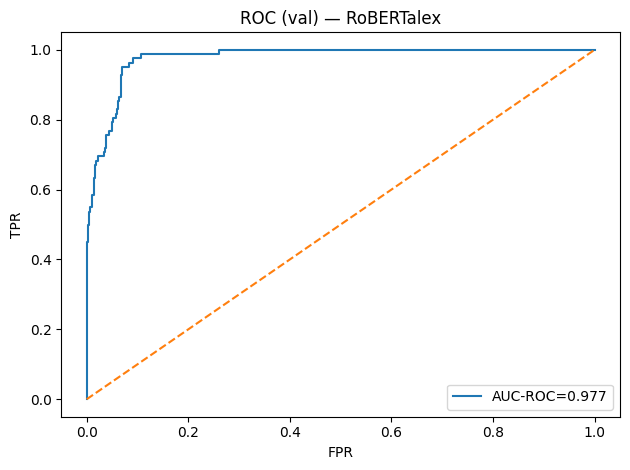

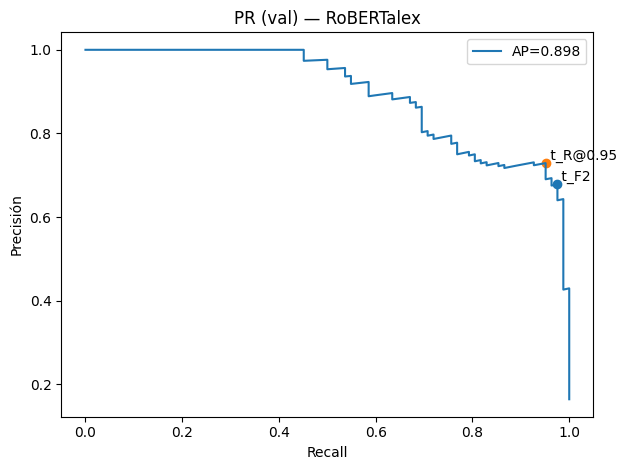

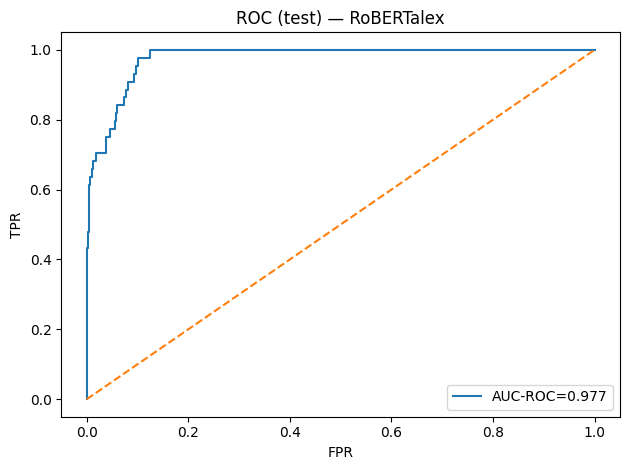

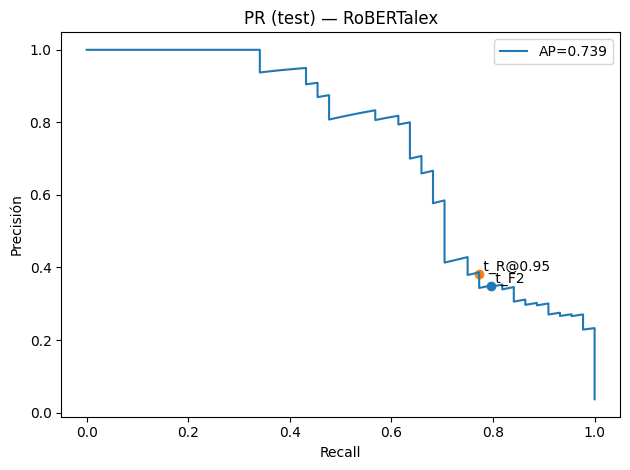

Gráficos guardados en: /content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml/plots/finetuning/ft_v1


In [12]:

def plot_roc(y_true, scores, title, out_png):
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC-ROC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()

def plot_pr(y_true, scores, title, out_png, marks: List[Tuple[str, float]] = None):
    prec, rec, _ = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)
    plt.figure()
    plt.plot(rec, prec, label=f"AP={ap:.3f}")
    if marks:
        for label, thr in marks:
            y_hat = (scores >= thr).astype(int)
            p, r, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
            plt.scatter([r],[p], marker='o')
            plt.text(r, p, f" {label}", va='bottom')
    plt.xlabel("Recall")
    plt.ylabel("Precisión")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()

# VAL
plot_roc(y_val, scores_val, f"ROC (val) — {os.path.basename(CHECKPOINT)}", f"{OUT_PLOTS}/roc_val_{os.path.basename(CHECKPOINT)}.png")
plot_pr(y_val, scores_val, f"PR (val) — {os.path.basename(CHECKPOINT)}",
        f"{OUT_PLOTS}/pr_val_{os.path.basename(CHECKPOINT)}.png",
        marks=[("t_F2", tF2), (f"t_R@{RECALL_TARGET:.2f}", tRX)])

# TEST
plot_roc(y_test, scores_test, f"ROC (test) — {os.path.basename(CHECKPOINT)}", f"{OUT_PLOTS}/roc_test_{os.path.basename(CHECKPOINT)}.png")
plot_pr(y_test, scores_test, f"PR (test) — {os.path.basename(CHECKPOINT)}",
        f"{OUT_PLOTS}/pr_test_{os.path.basename(CHECKPOINT)}.png",
        marks=[("t_F2", tF2), (f"t_R@{RECALL_TARGET:.2f}", tRX)])

print("Gráficos guardados en:", OUT_PLOTS)


## 12) Notas y próximos pasos
- Para comparar **otro checkpoint** (p. ej., `dccuchile/bert-base-spanish-wwm-cased`), cambiá `CHECKPOINT` en la **Celda 5** y repetí desde la **Celda 6**.
- Si falta VRAM:
  - Bajá `MAX_LEN` (512→448/384), `BATCH_TRAIN` (8→6/4) y subí `GRAD_ACCUM`.
  - Activá `USE_GC=True` (gradient checkpointing).
  - Considerá **PEFT/LoRA** si querés reducir aún más memoria/tiempo.
- Reportá **AUC-PR y AUC-ROC**, y métricas al **punto operativo** (\(t_{F2}\), \(t_{R@X}\)).
